# Imports 

In [1]:
# Data Processing
import pandas as pd 
import numpy as np 
import scipy.io 

import warnings
warnings.filterwarnings('ignore')

# Plotting 
import seaborn as sns
import matplotlib.image as mpimg 
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt 
from matplotlib import style
import mpl_toolkits.mplot3d.axes3d 

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation, rc
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = "/usr/bin/ffmpeg"
style.use('ggplot')

# Machine Learning 
import sklearn 
# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
# Model Selection 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from statistics import mean
# Data Preprocessing
from sklearn.decomposition import PCA 
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, QuantileTransformer, LabelBinarizer
from sklearn.pipeline import Pipeline
# Saving models 
from sklearn.externals import joblib 

Now to get the data. 

In [2]:
emitter_mat = scipy.io.loadmat("Emitter_cir_noise.mat")
cal_cir_mat = scipy.io.loadmat("cal_cir_noise.mat")
dataset_mat = scipy.io.loadmat("dataset_cir.mat")

train_df = pd.DataFrame(dataset_mat['dataset_cir'])
val_df = pd.DataFrame(cal_cir_mat['cal_cir_noise'])
test_df = pd.DataFrame(emitter_mat['Emitter_cir_noise'])

Process data by rounding the latitudes and longitudes to the nearest 10s. 

In [3]:
def get_noise(X):
    noise = np.zeros(X.shape)
    for idx, column in enumerate(X):
        mu, sigma = X[column].mean(), X[column].std()
        noise[:, idx] = np.random.normal(0, 0.1*sigma, [X.shape[0], 1]).ravel()

    return noise

def process_data(debug=False, rounding_factor = 10.0):

    global train_df
    global val_df
    global test_df
        
    # Drop the z-axis coordinates 
    train_df = train_df.drop(columns=2)
    val_df = val_df.drop(columns=2)
    test_df = test_df.drop(columns=2)
    
    train_df[0] = round(train_df[0] / rounding_factor) * rounding_factor
    val_df[0] = round(val_df[0] / rounding_factor) * rounding_factor
    test_df[0] = round(test_df[0] / rounding_factor) * rounding_factor
    
    train_df[1] = round(train_df[1] / rounding_factor) * rounding_factor
    val_df[1] = round(val_df[1] / rounding_factor) * rounding_factor
    test_df[1] = round(test_df[1] / rounding_factor) * rounding_factor
    
    train_df["combined_coords"] = train_df[0].map(str) + "_" + train_df[1].map(str)
    val_df["combined_coords"] = val_df[0].map(str) + "_" + val_df[1].map(str)
    test_df["combined_coords"] = test_df[0].map(str) + "_" + test_df[1].map(str)
    
    if debug:
        print(comb_dataset_df.shape)
        print(comb_dataset_df.head())
        print(comb_dataset_df.describe())

In [4]:
process_data(rounding_factor=50.0, debug=False)

Split the data into training, validation and testing sets. 

In [5]:
X_train = train_df.drop(columns=[0,1, "combined_coords"])
X_val = val_df.drop(columns=[0,1, "combined_coords"])
X_test = test_df.drop(columns=[0,1, "combined_coords"])
X_enhanced = pd.concat([X_train, X_val], ignore_index=True)

X_noisy_val = get_noise(X_val) + X_val
X_noisy_test = get_noise(X_test) + X_test
X_noisy_enhanced = pd.concat([X_train, pd.DataFrame(X_noisy_val)], ignore_index=True)

y_train = train_df["combined_coords"]
y_val = val_df["combined_coords"]
y_test = test_df["combined_coords"]

y_enhanced_train = pd.concat([y_train, y_val], ignore_index=True)
y_enhanced_test = test_df["combined_coords"]

Perform scaling using StandardScaler and then using PCA. 

In [6]:
pca = PCA(n_components=8)

X_knn_pipeline = Pipeline([
    ('minmax', MinMaxScaler()), 
    ('PCA', pca)
])

X_nn_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

In [7]:
''' Random Forest ''' 
X_rf_train = np.array(X_train) 
X_rf_val = np.array(X_val) 
X_rf_test = np.array(X_test)

X_rf_noisy_val = np.array(X_noisy_val)
X_rf_noisy_test = np.array(X_noisy_test)

# Enhanced Set 
X_rf_enh_train = np.array(X_enhanced)
X_rf_enh_test = np.array(X_test)

X_rf_noisy_enh_train = np.array(X_noisy_enhanced)
X_rf_noisy_enh_test = np.array(X_noisy_test)


''' K-Nearest Neighbors '''
X_knn_train = X_knn_pipeline.fit_transform(X_train)
X_knn_val = X_knn_pipeline.transform(X_val)
X_knn_test = X_knn_pipeline.transform(X_test)

X_knn_noisy_val = X_knn_pipeline.transform(X_noisy_val)
X_knn_noisy_test = X_knn_pipeline.transform(X_noisy_test)

# Enhanced Set 
X_knn_enh_train = X_knn_pipeline.fit_transform(X_enhanced)
X_knn_enh_test = X_knn_pipeline.transform(X_test)

# Create a noise enhanced dataset
X_knn_noisy_enh_train = X_knn_pipeline.fit_transform(X_noisy_enhanced)
X_knn_noisy_enh_test = X_knn_pipeline.transform(X_noisy_test)

''' Deep Neural Network ''' 
X_nn_train = X_nn_pipeline.fit_transform(X_train)
X_nn_val = X_nn_pipeline.transform(X_val)
X_nn_test = X_nn_pipeline.transform(X_test)

X_noisy_nn_val = X_nn_pipeline.transform(X_noisy_val)
X_noisy_nn_test = X_nn_pipeline.transform(X_noisy_test)

# Enhanced Set 
X_nn_enh_train = X_nn_pipeline.fit_transform(X_enhanced)
X_nn_enh_test = X_nn_pipeline.transform(X_test)

# Create a noisy enhanced dataset 
X_nn_noisy_enh_train = X_nn_pipeline.fit_transform(X_noisy_enhanced)
X_nn_noisy_enh_test = X_nn_pipeline.transform(X_noisy_test)

In [8]:
# Labels for Neural Network Training 

label_binarizer = LabelBinarizer()
label_binarizer_enh = LabelBinarizer()

y_nn_train = label_binarizer.fit_transform(y_train)
y_nn_val = label_binarizer.transform(y_val)
y_nn_test = label_binarizer.transform(y_test)

y_nn_enh_train = label_binarizer_enh.fit_transform(y_enhanced_train)
y_nn_enh_test = label_binarizer_enh.transform(y_enhanced_test)

In [9]:
def euclidean_error(model, X_test, y_test): 
    error = []
    for i in range(len(y_test)):
        label = str(model.predict(X_test[i].reshape(1,-1)))[2:-2]
        pred_lat = float(label.split('_')[0])
        pred_long = float(label.split('_')[1])
        
        test_lat = float(str(y_test.iloc[i]).split('_')[0])
        test_long = float(str(y_test.iloc[i]).split('_')[1])
        
        euclidean_error = np.sqrt((pred_long-test_long)**2 + (pred_lat-test_lat)**2)
        error.append(euclidean_error)
        
    print("Mean: {}".format(mean(error)))
    return mean(error)

def accuracy(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: {}".format(accuracy))
    
def plot_2D_predictions(model, range_beg, range_end, X_test, y_test):

    plt.xlabel('Latitude')
    plt.ylabel('Longitude')

    y_pred_lat = []
    y_pred_long = []
    y_test_lat = []
    y_test_long = []
    
    for i in range(range_beg, range_end):
        label = str(model.predict(X_test[i].reshape(1,-1)))[2:-2]
        
        pred_lat = float(label.split('_')[0])
        pred_long = float(label.split('_')[1])
        
        test_lat = float(str(y_test.iloc[i]).split('_')[0])
        test_long = float(str(y_test.iloc[i]).split('_')[1])
        
        y_pred_lat.append(pred_lat)
        y_pred_long.append(pred_long)
        y_test_lat.append(test_lat)
        y_test_long.append(test_long)
        
        plt.plot([pred_lat, test_lat], [pred_long, test_long], color='red', marker='.')
    
    plt.plot(y_pred_lat[range_beg:range_end], y_pred_long[range_beg:range_end], 'g.')
    plt.plot(y_test_lat[range_beg:range_end], y_test_long[range_beg:range_end], 'b.')
    
    y_lat = y_pred_lat + y_test_lat 
    y_long = y_pred_long + y_test_long 
    
    plt.xlim(int(min(y_lat)) - 100, int(max(y_lat)) + 100)
    plt.ylim(int(min(y_long)) - 100, int(max(y_long)) + 100)
    
    plt.show()

# Random Forest Classification

## Non-Enhanced Dataset

Validation Set
Mean: 12.650428131110349
Accuracy: 0.8947191389169189


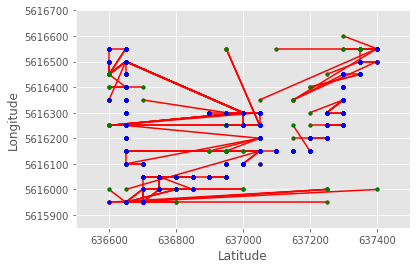

Testing Set
Mean: 32.0
Accuracy: 0.36


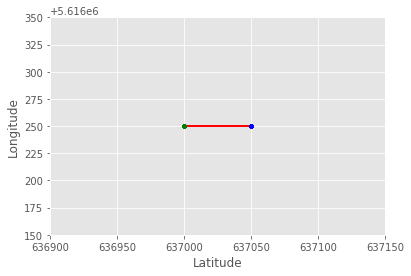

Noisy Validation Set
Mean: 67.96401221027811
Accuracy: 0.39387823747056844


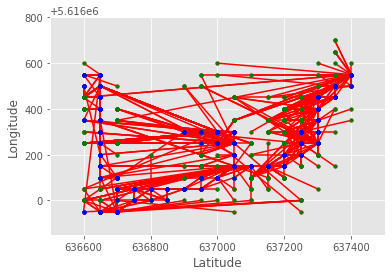

Noisy Testing Set
Mean: 32.0
Accuracy: 0.36


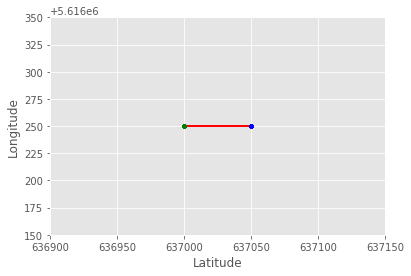

In [10]:
filename = "./Classification Models/rf_clf_10.sav"
train_flag = False
if train_flag:
    print('Training...')
    rf = RandomForestClassifier(n_estimators=10, random_state=42)
    rf.fit(X_rf_train, y_train)
    print('Training completed!')
    joblib.dump(rf, filename)
else:
    # This may not work because of memory issues in which case rerun the model 
    rf = joblib.load(filename)

print("Validation Set")
euclidean_error(rf, X_rf_val, y_val)
accuracy(rf, X_rf_val, y_val)
plot_2D_predictions(rf, 1, len(y_val), X_rf_val, y_val)

print("Testing Set")
euclidean_error(rf, X_rf_test, y_test)
accuracy(rf, X_rf_test, y_test)
plot_2D_predictions(rf, 1, len(y_test), X_rf_test, y_test)

print("Noisy Validation Set")
euclidean_error(rf, X_rf_noisy_val, y_val)
accuracy(rf, X_rf_noisy_val, y_val)
plot_2D_predictions(rf, 1, len(y_val), X_rf_noisy_val, y_val)

print("Noisy Testing Set")
euclidean_error(rf, X_rf_noisy_test, y_test)
accuracy(rf, X_rf_noisy_test, y_test)
plot_2D_predictions(rf, 1, len(y_test), X_rf_noisy_test, y_test)

## Enhanced Dataset 

Testing Set
Mean: 0.0
Accuracy: 1.0


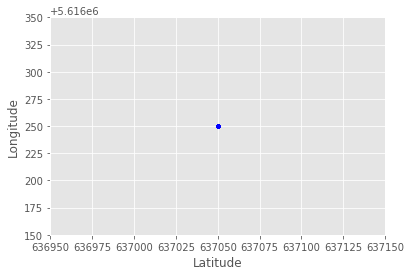

Noise Test Set
Mean: 0.0
Accuracy: 1.0


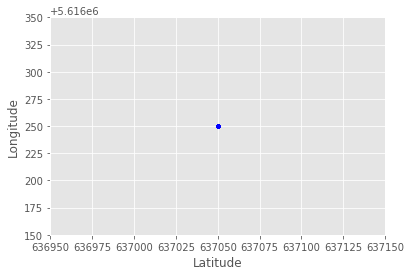

In [11]:
filename = "./Classification Models/rf_enhanced_clf_10.sav"
train_flag = True
if train_flag:
    rf_enhanced = RandomForestClassifier(n_estimators=10, random_state=42)
    rf_enhanced.fit(X_rf_enh_train, y_enhanced_train)
    joblib.dump(rf_enhanced, filename)
else:
    # This may not work because of memory issues in which case rerun the model 
    rf_enhanced = joblib.load(filename)
    
print("Testing Set")
euclidean_error(rf_enhanced, X_rf_enh_test, y_enhanced_test)
accuracy(rf_enhanced, X_rf_enh_test, y_enhanced_test)
plot_2D_predictions(rf_enhanced, 1, len(y_enhanced_test), 
                    X_rf_enh_test, y_enhanced_test)

print("Noise Test Set")
euclidean_error(rf_enhanced, X_rf_noisy_enh_test, y_enhanced_test)
accuracy(rf_enhanced, X_rf_noisy_enh_test, y_enhanced_test)
plot_2D_predictions(rf_enhanced, 1, len(y_enhanced_test), 
                    X_rf_noisy_enh_test, y_enhanced_test)

# K Nearest Neighbors 

## Non-Enhanced Dataset

Validation Set
Mean: 37.6475045470101
Accuracy: 0.6491759165825766


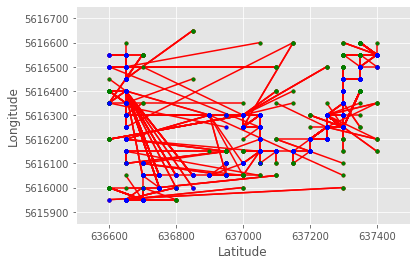

Testing Set
Mean: 0.0
Accuracy: 1.0


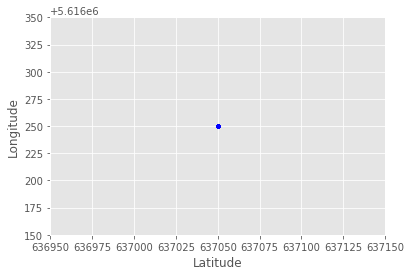

Noise Validatio  Set
Mean: 53.411639837579955
Accuracy: 0.5539858728557013


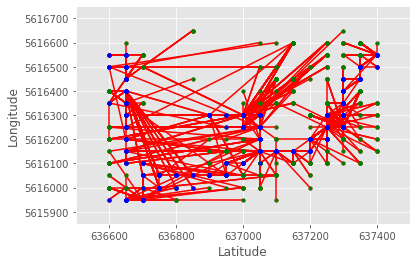

Noise Test Set
Mean: 0.0
Accuracy: 1.0


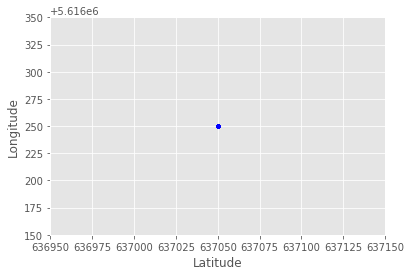

In [12]:
filename = "./Classification Models/knn_clf_10.sav"
train_flag = True 
if train_flag:
    knn = KNeighborsClassifier()
    knn.fit(X_knn_train, y_train)
    joblib.dump(knn, filename)
else:
    knn = joblib.load(filename)

print("Validation Set")
euclidean_error(knn, X_knn_val, y_val)
accuracy(knn, X_knn_val, y_val)
plot_2D_predictions(knn, 1, len(y_val), X_knn_val, y_val)

print("Testing Set")
euclidean_error(knn, X_knn_test, y_test)
accuracy(knn, X_knn_test, y_test)
plot_2D_predictions(knn, 1, len(y_test), X_knn_test, y_test)

print("Noise Validatio  Set")
euclidean_error(knn, X_knn_noisy_val, y_val)
accuracy(knn, X_knn_noisy_val, y_val)
plot_2D_predictions(knn, 1, len(y_val), X_knn_noisy_val, y_val)

print("Noise Test Set")
euclidean_error(knn, X_knn_noisy_test, y_test)
accuracy(knn, X_knn_noisy_test, y_test)
plot_2D_predictions(knn, 1, len(y_test), X_knn_noisy_test, y_test)

## Enhanced Dataset

Testing Set
Mean: 0.0
Accuracy: 1.0


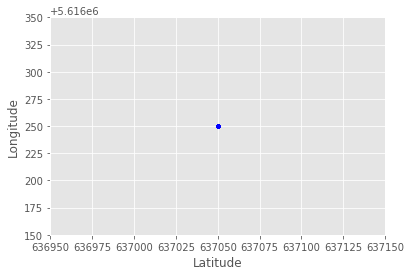

Noise Set
Mean: 223.60679774997897
Accuracy: 0.0


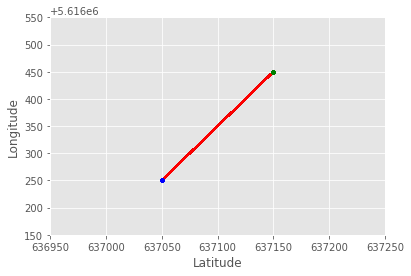

In [13]:
filename = "./Classification Models/knn_enhanced_clf_10.sav"
train_flag = True 
if train_flag:
    knn_enhanced = KNeighborsClassifier()
    knn_enhanced.fit(X_knn_enh_train, y_enhanced_train)
    joblib.dump(knn_enhanced, filename)
else:
    knn_enhanced = joblib.load(filename)

print("Testing Set")
euclidean_error(knn_enhanced, X_knn_enh_test, y_enhanced_test)
accuracy(knn_enhanced, X_knn_enh_test, y_enhanced_test)
plot_2D_predictions(knn_enhanced, 1, len(y_enhanced_test), 
                    X_knn_enh_test, 
                    y_enhanced_test)

print("Noise Set")
euclidean_error(knn_enhanced, X_knn_noisy_enh_test, y_enhanced_test)
accuracy(knn_enhanced, X_knn_noisy_enh_test, y_enhanced_test)
plot_2D_predictions(knn_enhanced, 1, len(y_test), X_knn_noisy_enh_test,
                    y_enhanced_test)

# Deep Neural Network 

In [14]:
hyperparameters = {'epochs': 100, # SGD hyperparameter
                   'batch_size': 32, # SGD hyperparameter
                   'lambd': None, # L2 regularization term
                   'dropout': 0.25} # dropout probability for dropout regularization

In [15]:
y_nn_train.shape

(127434, 272)

In [16]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import metrics, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers 
from tensorflow.keras.regularizers import l1, l2, l1_l2 

def build_model(X, num_classes=72):
    model = keras.Sequential([
    keras.layers.Dense(500, 
                       input_shape=(X.shape[1],), 
                       kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
                       activity_regularizer=l2(0.01)),
    keras.layers.BatchNormalization(), 
    keras.layers.ELU(), 
    keras.layers.Dropout(0.5),
    keras.layers.Dense(500, 
                       kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
                       activity_regularizer=l2(0.01)),
    keras.layers.BatchNormalization(), 
    keras.layers.ELU(), 
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, 
                       activation='softmax', 
                       kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
                       activity_regularizer=l2(0.001))])
        
    sgd = optimizers.SGD(lr=0.001, decay=1e-3, nesterov=True)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=sgd, 
                  metrics=[metrics.categorical_accuracy])
    model.summary()
    return model

In [17]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure() 
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    #plt.ylim([0,1])
    plt.legend()
    plt.show()

def plot_2D_predictions_nn(model, range_beg, range_end, X_test, y_test, enh):

    plt.xlabel('Latitude')
    plt.ylabel('Longitude')

    y_pred_lat = []
    y_pred_long = []
    y_test_lat = []
    y_test_long = []
    
    if enh: 
        lb = label_binarizer_enh
    else:
        lb = label_binarizer
        
    for i in range(range_beg, range_end):
        pred = model.predict(X_test[i].reshape(1,-1))     
        pred = lb.inverse_transform(pred) 
        
        label = str(pred)[2:-2]
        pred_lat = float(label.split('_')[0])
        pred_long = float(label.split('_')[1])
        
        y_pred_lat.append(pred_lat)
        y_pred_long.append(pred_long)
        
        test = lb.inverse_transform(y_test[i].reshape(1,-1))
        
        test_label = str(test)[2:-2]
        test_lat = float(test_label.split('_')[0])
        test_long = float(test_label.split('_')[1])
                
        y_test_lat.append(test_lat)
        y_test_long.append(test_long)
        
        plt.plot([pred_lat, test_lat], [pred_long, test_long], color='red', marker='.')
    
    plt.plot(y_pred_lat[range_beg:range_end], y_pred_long[range_beg:range_end], 'g.')
    plt.plot(y_test_lat[range_beg:range_end], y_test_long[range_beg:range_end], 'b.')
    
    y_lat = y_pred_lat + y_test_lat 
    y_long = y_pred_long + y_test_long 
    
    plt.xlim(int(min(y_lat)) - 100, int(max(y_lat)) + 100)
    plt.ylim(int(min(y_long)) - 100, int(max(y_long)) + 100)
    
    plt.show()

def euclidean_error_nn(model, X, y, enh): 
    error = []
    
    if enh: 
        lb = label_binarizer_enh
    else: 
        lb = label_binarizer
        
    for i in range(y.shape[0]):
        pred = model.predict(X[i].reshape(1,-1))
        pred = lb.inverse_transform(pred)         
        label = str(pred)[2:-2]
        pred_lat = float(label.split('_')[0])
        pred_long = float(label.split('_')[1])
        
        test = lb.inverse_transform(y[i].reshape(1,-1))        
        test_label = str(test)[2:-2]
        test_lat = (float(test_label.split('_')[0]))
        test_long = (float(test_label.split('_')[1]))
                        
        euclidean_error = np.sqrt((pred_long-test_long)**2 + (pred_lat-test_lat)**2)
        error.append(euclidean_error)
        
    print("Mean: {}".format(mean(error)))
    return mean(error)
    
def accuracy_nn(model, X, y, enh):
    if enh: 
        lb = label_binarizer_enh
    else: 
        lb = label_binarizer
    
    preds = model.predict(X)
    y_preds = lb.inverse_transform(preds)
    y_gt = lb.inverse_transform(y)
    
    print("Accuracy: {}".format(accuracy_score(y_preds, y_gt)))
    return accuracy_score(y_preds, y_gt)

def train_model(X, y, filename, save):
    model = build_model(X, 272)

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

    history = model.fit(X, y, 
              batch_size = hyperparameters['batch_size'], 
              epochs = hyperparameters['epochs'], 
              validation_split = 0.05,
              verbose = True, 
              shuffle = True, # shuffle training data before each epoch
              callbacks = [early_stop, rlrop]) 
    plot_history(history)
    
    if save: 
        model.save_weights('./Classification Models/{}_dnn_clf_weights_10.h5'.format(filename))
        # Save the model architecture
        with open('./Classification Models/{}_dnn_clf_architecture_10.json'.format(filename), 'w') as f:
            f.write(model.to_json())
    return model     

## Non-Enhanced Dataset

In [18]:
filename = "normal"
train_flag = False
if train_flag:
    model = train_model(X_nn_train, y_nn_train, filename, True)

# Model reconstruction from JSON file
with open('./Classification Models/normal_dnn_clf_architecture_10.json', 'r') as f:
    model = keras.models.model_from_json(f.read())
# Load weights into the new model
model.load_weights('./Classification Models/normal_dnn_clf_weights_10.h5')

Validation Set
Mean: 119.1978414256425
Accuracy: 0.2065253952236798


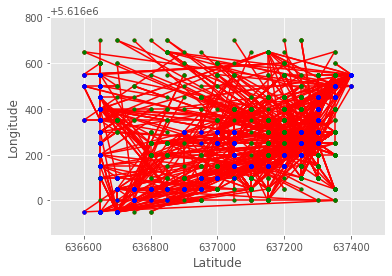

Testing Set
Mean: 70.71067811865476
Accuracy: 0.0


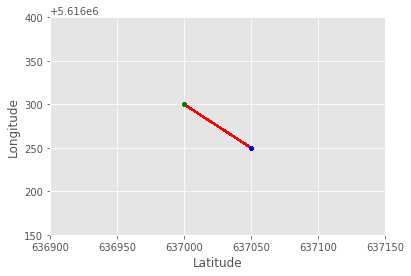

Noise Set
Mean: 70.71067811865476
Accuracy: 0.0


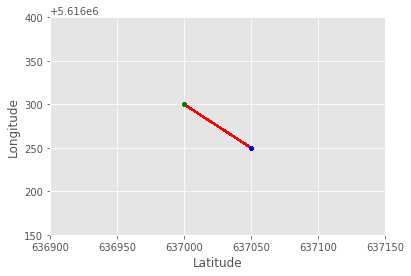

In [19]:
warnings.filterwarnings(action='once')

print("Validation Set")
euclidean_error_nn(model, X_nn_val, y_nn_val, enh=False)
accuracy_nn(model, X_nn_val, y_nn_val, False)
plot_2D_predictions_nn(model, 1, y_nn_val.shape[0], X_nn_val, y_nn_val, False)

print("Testing Set")
euclidean_error_nn(model, X_nn_test, y_nn_test, enh=False)
accuracy_nn(model, X_nn_test, y_nn_test, False)
plot_2D_predictions_nn(model, 1, y_nn_test.shape[0], X_nn_test, y_nn_test, False)

print("Noise Set")
euclidean_error_nn(model, X_noisy_nn_test, y_nn_test, enh=False)
accuracy_nn(model, X_noisy_nn_test, y_nn_test, False)
plot_2D_predictions_nn(model, 1, y_nn_test.shape[0], X_noisy_nn_test, y_nn_test, False)

## Enhanced Dataset

In [20]:
filename = "enhanced"
train_flag = False 
if train_flag:
    model = train_model(X_nn_enhanced, y_nn_enhanced, filename, True)

# Model reconstruction from JSON file
with open('./Classification Models/enhanced_dnn_clf_architecture_10.json', 'r') as f:
     model = keras.models.model_from_json(f.read())
# # Load weights into the new model
model.load_weights('./Classification Models/enhanced_dnn_clf_weights_10.h5')

Testing Set
Mean: 54.33645309959959
Accuracy: 0.0


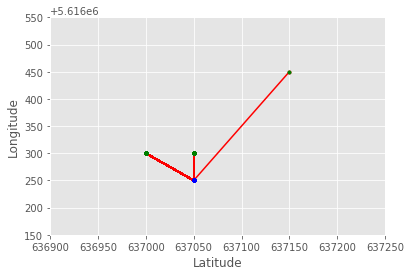

Noise Set
Mean: 54.39858513395555
Accuracy: 0.0


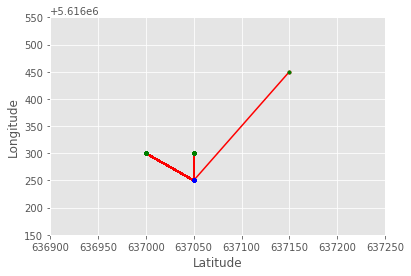

In [21]:
print("Testing Set")
euclidean_error_nn(model, X_nn_test, y_nn_test, enh=True)
accuracy_nn(model, X_nn_test, y_nn_test, enh=True)
plot_2D_predictions_nn(model, 1, y_nn_test.shape[0], X_nn_test, y_nn_test, enh=True)

print("Noise Set")
euclidean_error_nn(model, X_noisy_nn_test, y_nn_test, enh=True)
accuracy_nn(model, X_noisy_nn_test, y_nn_test, enh=True)
plot_2D_predictions_nn(model, 1, y_nn_test.shape[0], X_noisy_nn_test, y_nn_test, enh=True)

# Results and Evaluation

In [22]:
def get_error_list(model, X_test, y_test):
    error = []
    for i in range(len(y_test)):
        label = str(model.predict(X_test[i].reshape(1,-1)))[2:-2]
        pred_lat = float(label.split('_')[0])
        pred_long = float(label.split('_')[1])
        
        test_lat = float(str(y_test.iloc[i]).split('_')[0])
        test_long = float(str(y_test.iloc[i]).split('_')[1])
        
        euclidean_error = np.sqrt((pred_long-test_long)**2 + (pred_lat-test_lat)**2)
        error.append(euclidean_error)
    return error 

def get_error_list_nn(model, X_test, y_test, enh=False):
    error = []
    
    if enh:
        lb = label_binarizer_enh
    else:
        lb = label_binarizer
        
    for i in range(y_test.shape[0]):
        pred = model.predict(X_test[i].reshape(1,-1))
        pred = lb.inverse_transform(pred) 
        
        label = str(pred)[2:-2]
        pred_lat = float(label.split('_')[0])
        pred_long = float(label.split('_')[1])
        
        test = lb.inverse_transform(y_test[i].reshape(1,-1))
        
        test_label = str(test)[2:-2]
        test_lat = float(test_label.split('_')[0])
        test_long = float(test_label.split('_')[1])
                
        euclidean_error = np.sqrt((pred_long-test_long)**2 + (pred_lat-test_lat)**2)
        error.append(euclidean_error)
    return error 

y_val_lat = []
y_val_long = []

for i in range(len(y_val)):
    val_lat = float(str(y_val.iloc[i]).split('_')[0])
    val_long = float(str(y_val.iloc[i]).split('_')[1])
    y_val_lat.append(val_lat)
    y_val_long.append(val_long)

y_val_lat = np.array(y_val_lat)
y_val_long = np.array(y_val_long)

# Can choose between rf_reg and rf_reg_enhanced
rf_error = np.array(get_error_list(rf, X_rf_val, y_val)).ravel()
# Can choose between knn_reg and knn_reg_enhanced
knn_error = np.array(get_error_list(knn, X_knn_val, y_val)).ravel()
# Can choose between model and model_enhanced
dnn_error = np.array(get_error_list_nn(model, X_nn_val, y_nn_val)).ravel()

num_points = y_val_lat.shape[0]

In [23]:
# Create a table for analysis of errors 

err_table = pd.DataFrame({
    'Latitude': y_val_lat.reshape(-1,1).flatten(),
    'Longitude': y_val_long.reshape(-1,1).flatten(),
    'RF': rf_error.reshape(-1,1).flatten(),
    'KNN': knn_error.reshape(-1,1).flatten(),
    'DNN': dnn_error.reshape(-1,1).flatten(),
})

In [24]:
err_table.head()
err_table.to_csv("./Outputs/classification_errors.csv")

In [25]:
joblib.dump(X_knn_pipeline, 'Pipelines/clf_knn_pipeline.joblib')
joblib.dump(X_nn_pipeline, 'Pipelines/clf_nn_pipeline.joblib')
joblib.dump(label_binarizer, 'Pipelines/clf_y_lbl_binarizer.joblib')
joblib.dump(label_binarizer_enh, 'Pipelines/clf_y_lbl_binarizer_enh.joblib')

['Pipelines/clf_y_lbl_binarizer_enh.joblib']

# 2D Animations 

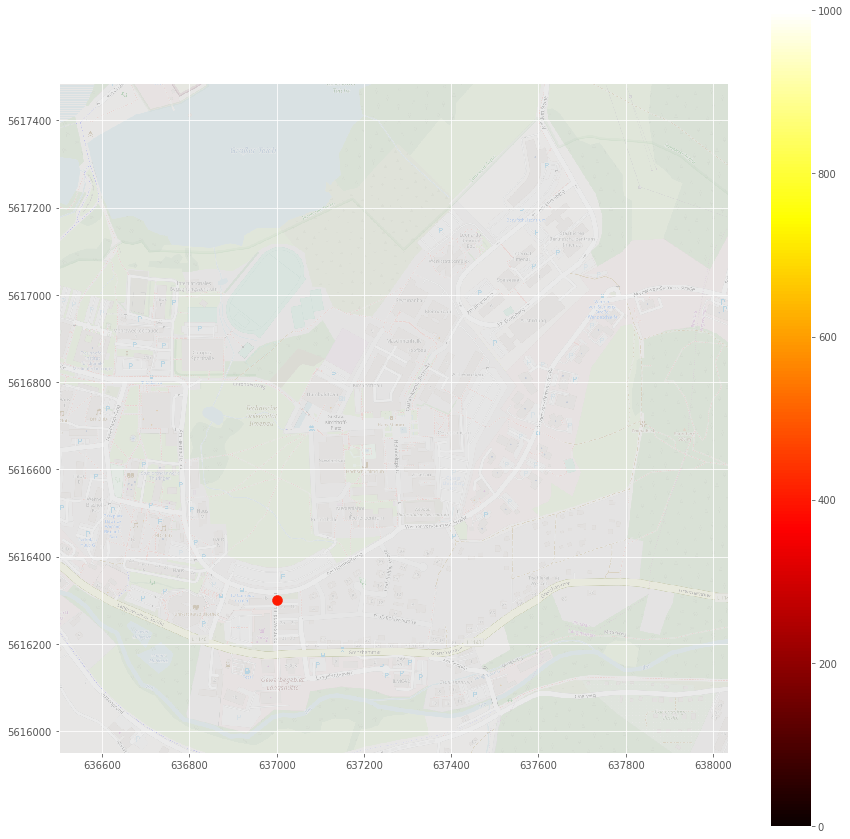

In [26]:
import matplotlib.pyplot as plt 
import matplotlib 

xlim1 = 636500
xlim2 = 638035
ylim1 = 5615950
ylim2 = 5617485

errors = rf_error 

fig, ax = plt.subplots(figsize=(15, 15))
img = plt.imread('base.png')
ax.imshow(img, extent=[636500, 638035, 5615950, 5617485], alpha=0.2)
x, y, s, c = [],[],[],[]
sc = ax.scatter(x,y,c=c, s=100,cmap='hot', vmin=0, vmax=1000) 
plt.xlim(xlim1, xlim2) 
plt.ylim(ylim1, ylim2)

def animate(i):
#     x.append(random.randrange(xlim1, xlim2))
#     y.append(random.randrange(ylim1, ylim2))
#     s.append(np.random.rand(1)*1000)

    x.append(y_val_lat[i])
    y.append(y_val_long[i])
    c.append(errors[i])
#     s.append(errors[i] * 5)
    sc.set_offsets(np.c_[x,y])
#     sc.set_sizes(np.reshape(np.array(s), (-1,)))
    sc.set_array(np.reshape(np.array(c), (-1,)))

ani = matplotlib.animation.FuncAnimation(fig, animate, 
                frames=num_points, interval=10, repeat=True) 
plt.colorbar(sc)
plt.show()

In [ ]:
plt.rcParams['animation.ffmpeg_path'] = "C:\\ffmpeg\\bin\\ffmpeg.exe"
print(num_points)
HTML(ani.to_html5_video())

# Appendix 

Training code for the neural network. Grid-Search for parameters. 

In [ ]:
# Skip this 
def build_model(X, num_classes, n_hidden, l2_reg, kl2_reg, dropout, lr, decay):
    model = keras.Sequential([
    keras.layers.Dense(n_hidden, activation='relu', 
                       kernel_initializer='normal', 
                       input_shape=(X.shape[1],), 
                       kernel_regularizer=l2(kl2_reg),
                       activity_regularizer=l2(l2_reg)),
    keras.layers.Dropout(dropout), 
    keras.layers.Dense(num_classes, 
                       activation='softmax', 
                       kernel_regularizer=l2(kl2_reg),
                       activity_regularizer=l2(l2_reg))])
        
    sgd = optimizers.SGD(lr=lr, decay=decay, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', 
                  optimizer=sgd, 
                  metrics=[metrics.categorical_accuracy])
    return model

batch_size = [200]
dropout = [0.2, 0.4, 0.5]
n_hidden = [160, 170, 180, 200]
learning_rate = [0.1, 0.25, 0.5]
decay = [1e-5, 1e-4, 1e-3, 1e-2]
l2_act_reg = [1e-5,1e-3,1e-3,1e-2]
l2_kernel_reg = [1e-5,1e-3,1e-3,1e-2]

grid_search = [(bs, d, h, lr, dec, areg, kreg) for bs in batch_size for d in dropout for 
               h in n_hidden for lr in learning_rate for dec in decay for areg in l2_act_reg
               for kreg in l2_kernel_reg] 

best_val = -1 
best_net = None
results = {}
best_hyperparams = {} 

for bs, d, h, lr, dec, areg, kreg in grid_search:
  # Bulld model 
  model = build_model(X_nn_train, 5732, h, areg, kreg, d, lr, dec) 

  # Train the model
  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
  history = model.fit(X_nn_train, y_nn_train, 
              batch_size = bs, 
              epochs = hyperparameters['epochs'], 
              validation_split = 0.2,
              verbose = False,  
              shuffle = True, # shuffle training data before each epoch
              callbacks = [early_stop]) 
  
  # Get training results 
  print('Training')
  train_error = euclidean_error_nn(model, X_nn_train, y_nn_train, enh=False)
  train_acc = accuracy_nn(model, X_nn_train, y_nn_train, False)

  # Get validation results 
  print('Validation')
  val_error = euclidean_error_nn(model, X_nn_val, y_nn_val, enh=False)
  val_acc = accuracy_nn(model, X_nn_val, y_nn_val, False)

  results[(bs,d,h,lr,dec,reg)] = (train_error, train_acc, val_error, val_acc)

  if val_error > best_val:
    best_val = val_error
    best_net = model 
    best_hyperparams[(bs,d,h,lr,dec,reg)] = val_error
  